<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) 

If latest package show errors please downgrade.

In [ ]:
!cp -r /content/drive/MyDrive/Innohack/weed_training .

In [ ]:
!pip install tflite-model-maker==0.3.3

In [ ]:
!pip install tflite-support==0.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the required packages.

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector


from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

ModuleNotFoundError: ignored

## Train the object detection model

### Step 1: Load the dataset

Copy all the images to `train_images` folder

* Images in `train_images_final` is used to train the custom object detection model.
* Images in `test` is used to check if the model can generalize well to new images that it hasn't seen before.

# Convert image
**For training please use the image in JPEG format. Otherwise errors will be thrown.**

Please run the below code to organize images with respective XML File 
Specify the path of the folder where images are stored in the below cell. Here it is `train_images`

After running the below cell images will be arranged with its XML and will be saved in `train_images_final` folder






In [ ]:
import glob
from PIL import Image

for i in range(len(glob.glob('hjjk*.jpeg'))):
  img = Image.open(glob.glob('/content/drive/MyDrive/Innohack/weed_training/train/*.jpeg')[i])
  rgb_img = img.convert('RGB')
  rgb_img.save('/content/train_images_final/'+glob.glob('/content/drive/MyDrive/Innohack/weed_training/train/*.jpeg')[i].rsplit('/')[-1])

FileNotFoundError: ignored

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/MyDrive/Innohack/weed_training/train',
    '/content/drive/MyDrive/Innohack/weed_training/train',
    ['normal', 'damaged']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/MyDrive/Innohack/weed_training/test',
    '/content/drive/MyDrive/Innohack/weed_training/test',
    ['normal', 'damaged']
)

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |



Use EfficientDet-Lite0 to train our model. Also we can choose other model architectures depending on whether speed or accuracy is more important to you.

In [ ]:
spec = model_spec.get('efficientdet_lite0')

### Step 3: Train the TensorFlow model with the training data.



In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=32, train_whole_model=True, epochs=50, validation_data=val_data)

Epoch 1/50
2/2 [==============================] - 68s 5s/step - det_loss: 1.8195 - cls_loss: 1.1243 - box_loss: 0.0139 - reg_l2_loss: 0.0629 - loss: 1.8824 - learning_rate: 0.0187 - gradient_norm: 0.8195
Epoch 2/50
2/2 [==============================] - 9s 9s/step - det_loss: 1.7572 - cls_loss: 1.1151 - box_loss: 0.0128 - reg_l2_loss: 0.0629 - loss: 1.8201 - learning_rate: 0.0399 - gradient_norm: 0.7787
Epoch 3/50
2/2 [==============================] - 19s 10s/step - det_loss: 1.6946 - cls_loss: 1.0868 - box_loss: 0.0122 - reg_l2_loss: 0.0629 - loss: 1.7576 - learning_rate: 0.0398 - gradient_norm: 0.7460
Epoch 4/50
2/2 [==============================] - 22s 10s/step - det_loss: 1.6501 - cls_loss: 1.0418 - box_loss: 0.0122 - reg_l2_loss: 0.0629 - loss: 1.7130 - learning_rate: 0.0395 - gradient_norm: 0.9089
Epoch 5/50
2/2 [==============================] - 21s 12s/step - det_loss: 1.4751 - cls_loss: 0.9403 - box_loss: 0.0107 - reg_l2_loss: 0.0629 - loss: 1.5380 - learning_rate: 0.0392 - 

### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use  images in the test  dataset to evaluate how the model performs against new data it has never seen before.




In [ ]:
model.evaluate(val_data)

1/1 [==============================] - 8s 8s/step



{'AP': 0.35298982,
 'AP50': 0.8470475,
 'AP75': 0.24402574,
 'APs': -1.0,
 'APm': 0.33088234,
 'APl': 0.35551178,
 'ARmax1': 0.22714286,
 'ARmax10': 0.49714285,
 'ARmax100': 0.5278571,
 'ARs': -1.0,
 'ARm': 0.5,
 'ARl': 0.5277778,
 'AP_/normal': 0.39657453,
 'AP_/damaged': 0.30940512}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. 

In [ ]:
model.export(export_dir='.', tflite_filename='android.tflite')

NameError: ignored

### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('android.tflite', val_data)

9/9 [==============================] - 23s 2s/step



{'AP': 0.32865217,
 'AP50': 0.8410577,
 'AP75': 0.20517051,
 'APs': -1.0,
 'APm': 0.28333333,
 'APl': 0.33100757,
 'ARmax1': 0.22,
 'ARmax10': 0.46214285,
 'ARmax100': 0.46214285,
 'ARs': -1.0,
 'ARm': 0.45,
 'ARl': 0.46239316,
 'AP_/normal': 0.385104,
 'AP_/damaged': 0.27220038}

In [ ]:
# Download the TFLite model to your local computer.
from google.colab import files
files.download('android.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the Android figurine detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

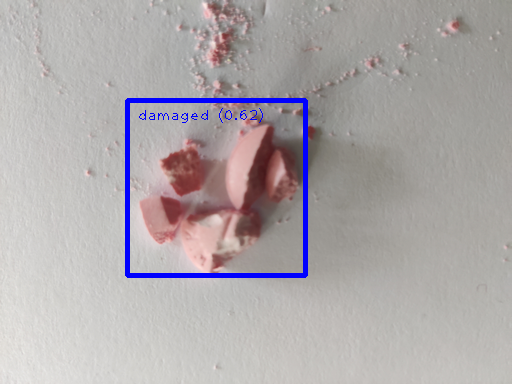

In [ ]:
#@title Run object detection and show the detection results

from PIL import Image

#INPUT_IMAGE_URL = "http://download.tensorflow.org/example_images/android_figurine.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "android.tflite" #@param {type:"string"}

TEMP_FILE = '//content/drive/MyDrive/pill_labelled/test/IMG_20220915_125226.jpeg'


image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

In [ ]:
!pip install tflite_support_nightly


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.2 MB 1.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tflite-support 0.3.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 2.0.7 which is incompatible.
tflite-model-maker 0.3.3 requires flatbuffers==1.12, but you have flatbuffers 2.0.7 which is incompatible.


In [ ]:
import argparse
import sys
import time
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tflite_support.task import core
from tflite_support.task import processor
from tflite_support.task import vision


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red

FILE_OUTPUT = '</content/video>.avi'
cap = cv2.VideoCapture("/content/smoke.mp4")


def visualize(
    image: np.ndarray,
    detection_result: processor.DetectionResult,
) -> np.ndarray:

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + bbox.origin_x,
                     _MARGIN + _ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image



  # if __name == '__main__':
  #   cap = cv2.VideoCapture("/content/videoblocks-4k-fire-thick-smoke-billowing-from-burning-firepit_hdpcfel6l__8378c488e8187245aaf9954337ea89d0__P360.mp4")
  #   start_time = time.time()
  #   frame_width = int(video_capture.get(3))
  #   frame_height = int(video_capture.get(4))
  #   size = (frame_width, frame_height)

  #   result = cv2.VideoWriter('/mydrive/result.avi', cv2.VideoWriter_fourcc(*'MJPG'),15, size)


  #   row_size = 20  # pixels
  #   left_margin = 24  # pixels
  #   text_color = (0, 0, 255)  # red
  #   font_size = 1
  #   font_thickness = 1
  #   fps_avg_frame_count = 10


  #   while True:
  #     counter, fps = 0, 0
  #     base_options = core.BaseOptions(
  #       file_name="/content/android.tflite", use_coral=False, num_threads=4)
      
  #     detection_options = processor.DetectionOptions(
  #        max_results=3, score_threshold=0.3)
      
  #     options = vision.ObjectDetectorOptions(
  #    base_options=base_options, detection_options=detection_options)
      
  #   detector = vision.ObjectDetector.create_from_options(options)

  #   counter+=1

  #   ret, image = cap.read()

  #   if not ret:
  #     print("Unable to read video / Video ended")

      
  #   image = cv2.flip(image, 1)
  #   rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #   input_tensor = vision.TensorImage.create_from_array(rgb_image)
  #   detection_result = detector.detect(input_tensor)


  #   image = visualize(image, detection_result)


  #   if counter % fps_avg_frame_count == 0:
  #     end_time = time.time()
  #     fps = fps_avg_frame_count / (end_time - start_time)
  #     start_time = time.time()
      

  #   #  end_time = time.time()
  #   #  fps = fps_avg_frame_count / (end_time - start_time)
  #   #  start_time = time.time()

   

    



    

   
      

 



while True:

  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))

  out = cv2.VideoWriter(FILE_OUTPUT, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                      10, (frame_width, frame_height))



  row_size = 20  # pixels
  left_margin = 24  # pixels
  text_color = (0, 0, 255)  # red
  font_size = 1
  font_thickness = 1
  fps_avg_frame_count = 10

  

  counter, fps = 0, 0
  start_time = time.time()
  base_options = core.BaseOptions(
    file_name="/content/android (4).tflite", use_coral=False, num_threads=4)
  detection_options = processor.DetectionOptions(
    max_results=3, score_threshold=0.3)
  options = vision.ObjectDetectorOptions(
     base_options=base_options, detection_options=detection_options)
  detector = vision.ObjectDetector.create_from_options(options)



  
  counter += 1
 
  ret,image = cap.read()
  image = cv2.flip(image, 1)
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  input_tensor = vision.TensorImage.create_from_array(rgb_image)
  detection_result = detector.detect(input_tensor)
  image = visualize(image, detection_result)

  if counter % fps_avg_frame_count == 0:
     end_time = time.time()
     fps = fps_avg_frame_count / (end_time - start_time)
     start_time = time.time()

  fps_text = 'FPS = {:.1f}'.format(fps)
  text_location = (left_margin, row_size)
  cv2.putText(image, fps_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                font_size, text_color, font_thickness)
  
  if cv2.waitKey(1) == 27:
    print("HI")
   
  out.write(image)
  cv2_imshow(image)

cv2.destroyAllWindows()



if __name__ == '__main__':
  run()







RuntimeError: ignored

In [ ]:

import sys
import time
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tflite_support.task import core
from tflite_support.task import processor
from tflite_support.task import vision


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 3
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red



def visualize(
    image: np.ndarray,
    detection_result: processor.DetectionResult,
) -> np.ndarray:

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + bbox.origin_x,
                     _MARGIN + _ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image





if __name__ =="__main__" :


  video_capture = cv2.VideoCapture("/content/VID_20220919_095633.mp4")
  start_time = time.time()
  counter, fps = 0, 0

  frame_width = int(video_capture.get(3))
  frame_height = int(video_capture.get(4))

  size=(frame_width,frame_height)

  result = cv2.VideoWriter('/content/otuput/result.avi', cv2.VideoWriter_fourcc(*'MJPG'),20, size)

  #load Model
  base_options = core.BaseOptions(
    file_name="/content/android.tflite", use_coral=False, num_threads=4)
  detection_options = processor.DetectionOptions(
    max_results=10, score_threshold=0.5)
  options = vision.ObjectDetectorOptions(
     base_options=base_options, detection_options=detection_options)
  detector = vision.ObjectDetector.create_from_options(options)






  while True:

    ret, image = video_capture.read()

    if not ret:
      print("Unable to Read the video")
      break 
    
    image = cv2.flip(image, 1)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = vision.TensorImage.create_from_array(rgb_image)
    detection_result = detector.detect(input_tensor)

    image = visualize(image, detection_result)


    end_time = time.time()
    fps = int(3/(end_time - start_time))
    start_time = end_time
    cv2.putText(image, f"FPS: {fps}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

    result.write(image)

  video_capture.release()






    








Exception ignored in: <function TensorImage.__del__ at 0x7f3c1ce3b710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_lite_support/python/task/vision/core/tensor_image.py", line 104, in __del__
AttributeError: module 'tensorflow_lite_support.python.task.vision.core.pybinds.image_utils' has no attribute 'ImageDataFree'
Exception ignored in: <function TensorImage.__del__ at 0x7f3c1ce3b710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_lite_support/python/task/vision/core/tensor_image.py", line 104, in __del__
AttributeError: module 'tensorflow_lite_support.python.task.vision.core.pybinds.image_utils' has no attribute 'ImageDataFree'
Exception ignored in: <function TensorImage.__del__ at 0x7f3c1ce3b710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_lite_support/python/task/vision/core/tensor_image.py", line 104, in __del__
AttributeError: module 'tens

Unable to Read the video


Exception ignored in: <function TensorImage.__del__ at 0x7f3c1ce3b710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_lite_support/python/task/vision/core/tensor_image.py", line 104, in __del__
AttributeError: module 'tensorflow_lite_support.python.task.vision.core.pybinds.image_utils' has no attribute 'ImageDataFree'
